In [1]:
import os
from pydantic import BaseModel

In [90]:
os.environ['OPENAI_API_KEY'] = ''

In [91]:
class Settings(BaseModel):
    OPENAI_API_KEY: str = os.getenv("OPENAI_API_KEY", "")
    OPENAI_CHAT_MODEL: str = "gpt-4o-mini"
    OPENAI_EMBEDDINGS_URI: str = "https://api.openai.com/v1/embeddings"
    OPENAI_EMBEDDING_MODEL: str = "text-embedding-3-small"

    NEO4J_URI: str = os.getenv('NEO4J_URI', "bolt://localhost:7687")
    NEO4J_USERNAME: str = os.getenv('NEO4J_USERNAME', "neo4j")
    NEO4J_PASSWORD: str = os.getenv('NEO4J_PASSWORD', "mysupersecurepassword")
    NEO4J_DATABASE: str = os.getenv('NEO4J_DATABASE', "")

settings = Settings()

In [65]:
from typing import List, Tuple

In [66]:
def format_chat_history(messages):
    """
    Formats the chat history for inclusion in the prompt.

    Args:
        messages (list): A list of message objects (HumanMessage, ToolMessage, AIMessage).

    Returns:
        str: Formatted chat history as a string.
    """
    formatted_history = []
    for message in messages:
        if isinstance(message, HumanMessage):
            formatted_history.append(f"Human: {message.content}")
        elif isinstance(message, AIMessage):
            formatted_history.append(f"AI: {message.content}")
        elif isinstance(message, ToolMessage):
            formatted_history.append(f"Tool ({message.tool_name}): {message.content}")
    return "\n".join(formatted_history)


In [67]:
qa_prompt_template = """You are an assistant for question-answering tasks. """ \
"""Use the following pieces of retrieved context to answer the question. """ \
"""If you don't know the answer, explain that you need more context. """ \
"""Use three sentences maximum and keep the answer concise. \
Chat History: {chat_history}
Question: {question} 
Context: {context} 
Answer:"""

hallucination_prompt_template = """
     You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts.\n\n
     Set of facts: {documents} \n\n LLM generation: {generation}
     """

In [68]:
from pydantic import BaseModel, Field
from langchain.prompts import ChatPromptTemplate
from langchain_neo4j import Neo4jVector
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatOpenAI(model=settings.OPENAI_CHAT_MODEL, temperature=0)

neo4j_vector_store = Neo4jVector.from_existing_graph(
    embedding=OpenAIEmbeddings(model=settings.OPENAI_EMBEDDING_MODEL),
    url=settings.NEO4J_URI,
    username=settings.NEO4J_USERNAME,
    password=settings.NEO4J_PASSWORD,
    index_name="ChunkEmbedding",
    node_label="Chunk",
    text_node_properties=["text"],
    embedding_node_property="textEmbedding",
)

retriever = neo4j_vector_store.as_retriever()

qa_prompt = PromptTemplate(
    input_variables=["question", "context", "chat_history"],
    template=qa_prompt_template
)


qa_chain = qa_prompt | llm | StrOutputParser()

fallback_prompt = ChatPromptTemplate.from_template(
    """
    You are an assistant for question-answering tasks. Your task is to respond appropriately based on the nature of the question.

    If the question involves a business topic, is of significant importance, or you believe more context is needed to provide an accurate answer:
    1. Indicate that the context provided is insufficient to answer the question definitively.
    2. Mention that more specific information or additional documents are needed to answer the question accurately.
    3. Clearly state that you are providing a response based on general knowledge, and your answer may not be fully tailored to the provided documents.
    4. Encourage the user to provide more documents or clarify the question for a more accurate response.

    For questions that don't require additional context:
    1. Respond directly with the information you know, based on the context or general knowledge.

    Keep your response concise and no longer than three sentences. Be mindful to provide a tailored answer only when relevant, and when in doubt, ask for clarification or more details.\n\n
    Chat History: {chat_history}
    Question: {question}
    """
)




fallback_chain = fallback_prompt | llm | StrOutputParser()

class HallucinationEvaluator(BaseModel):
    """Binary score for hallucination present in generation answer."""

    grade: str = Field(...,
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )
    
hallucination_llm = llm.with_structured_output(HallucinationEvaluator)
hallucination_prompt = ChatPromptTemplate.from_template(hallucination_prompt_template)

hallucination_chain = hallucination_prompt | hallucination_llm

class AnswerabilityEvaluator(BaseModel):
    """Binary score for determining if a question is answerable using the provided documents."""
    grade: str = Field(..., description="Answer can be determined using the documents, 'yes' or 'no'")

answerability_llm = llm.with_structured_output(AnswerabilityEvaluator)
answerability_prompt_template = """
You are tasked with determining if a question can be answered strictly and exclusively using the provided documents.

Documents: {documents}
Question: {question}

Analyze the documents carefully and respond with "yes" only if the documents explicitly and exactly contain the information required to answer the question. The answer should match the question as closely as possible. Do not assume, infer, or extrapolate any information beyond what is clearly stated in the documents. If the documents do not exactly address the question, respond with "no".

Respond with "yes" or "no" only.
"""


answerability_prompt = ChatPromptTemplate.from_template(answerability_prompt_template)
answerability_chain = answerability_prompt | answerability_llm


In [69]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_pdf",
    "Retrieve pdf documents that could contain useful information."
)

In [70]:
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from typing import Annotated, List
from langchain_core.messages.base import BaseMessage


class GraphState(TypedDict):
    """
    Represents the state of our graph.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    

In [71]:
from langchain.schema import AIMessage

In [82]:
from langchain_core.messages import ToolMessage

def retrieve(state: GraphState):
    """
    Retrieves the documents from the vectorstore.
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    
    print(f"> 📃 Retrieving documents...")
    user_messages = [msg.content for msg in state["messages"] if isinstance(msg, HumanMessage)]
    query = user_messages[-1] if user_messages else ""
    
    retriever_input = {"query": query}
    
    response = retriever_tool.invoke(retriever_input)
    
    
    tool_message = ToolMessage(
        content=response,
        tool_name="retriever",
        tool_call_id='id'
    )

    return {"messages": [tool_message]}


def check_answerability(state: dict):
    """
    Check if the question can be answered based on the provided documents in the state.

    Args:
        state (dict): The current state containing documents and the question.

    Returns:
        str: "answerable" if the question can be answered, otherwise "not answerable".
    """
    messages = state["messages"]
    last_message = messages[-1]

    question = messages[-2].content
    docs = last_message.content

    if not docs or not question:
        print("> ❌ \033[91mMissing documents or question in the state\033[0m")
        return "not answerable"

    result = answerability_chain.invoke({"documents": docs, "question": question})
    
    if result.grade == "yes":
        print("> ✅ \033[92mThe question can be answered with the provided documents\033[0m")
        return "answerable"
    else:
        print("> ❌ \033[91mThe question cannot be answered with the provided documents\033[0m")
        return "not answerable"

def generate(state: GraphState):
    """
    Generates an answer using the retrieved documents/query results.
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print(f"> 🧠 Generating an answer ...")
    
    messages = state["messages"]
    question = messages[-2].content
    last_message = messages[-1]
    docs = last_message.content
    response = qa_chain.invoke({"question": question, "context": docs, "chat_history":format_chat_history(messages[:-2])})
    
    return {"messages": [AIMessage(content=response)]}


def fallback(state):
    """
    Fallback to LLM's internal knowledge.
    
    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print(f"> 👈 Fallback to LLM's internal knowledge ...")
    messages = state["messages"]
    question = messages[-2].content

    response = fallback_chain.invoke({"question": question, "chat_history":format_chat_history(messages[:-2])})
    
    return {"messages": [AIMessage(content=response)]}

def check_hallucination(state: GraphState):
    """
    Check if the generation is hallucinated.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    messages = state["messages"]
    last_message = messages[-1]

    docs = messages[-2].content
    generation = last_message.content
    
    grounded = hallucination_chain.invoke({"documents": docs, "generation": generation})
    
    if grounded.grade == "yes":
        print("> ✅ \033[92mAnswer addresses the question\033[0m")
        return "useful"
    
    else:
        print("> ❌ \033[91mGeneration is not grounded in the documents\033[0m")
        return "not supported"
    

In [83]:
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

workflow = StateGraph(GraphState)

workflow.add_node("retrieve", retrieve)
workflow.add_node("generate", generate)
workflow.add_node("fallback", fallback)


workflow.add_edge(START, 'retrieve')

workflow.add_conditional_edges(
    'retrieve',
    check_answerability,
    {
        "answerable": 'generate',
        "not answerable": 'fallback'
    }
)
workflow.add_conditional_edges(
    'generate',
    check_hallucination,
    {
        "useful": END,
        "not supported": 'fallback'
    }
)
#workflow.add_edge('generate', END)
workflow.add_edge('fallback', END)

graph = workflow.compile(checkpointer=memory)

In [84]:
from langchain_core.messages import HumanMessage
import pprint

inputs = {
    "messages": [
        HumanMessage(content="cual es la mision de la pdi?"),
    ]
}

for output in graph.stream(inputs, config={"configurable": {"thread_id": "1", "recursion_limit": 3}}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


> 📃 Retrieving documents...
> ❌ The question cannot be answered with the provided documents
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='\ntext: Recomendaciones  Macarena Larraín / Head of Product Get on Board  +56 9 6433 2530  Carlos Silva / CTO Delpa Group  +56 9 6433 2530  Daniela Kreimerman / Jefa Implementaciones Alloxentric  +56 9 3583 2144  Diego Herrera / Director DuocUC Viña del Mar  +56 9 9138 4379 \n\n\ntext: MARZO 2019 – DICIEMBRE 2022  Ingeniería en Informática / DuocUC, Viña del Mar  • Participar del centro de estudiantes CITT, destacando la Hackathon CITT I 2020 con MVP  para la trazabilidad del COVID-19. • Idea para reactivación económica de emprendedores turísticos NOVA RELAY 2020. \n\n\ntext: Experiencia  SEPTIEMBRE 2023 – MARZO 2024  Desarrollador Full Stack / Delpa Group  ▪ Crear las interfaces visuales UI/UX de la plataforma (React con TypeScript, MUI y  TailwindCSS). ▪ Desarrollar plataforma end-to-end (en NestJS con TypeScript) con im

In [85]:
from langchain_core.messages import HumanMessage
import pprint

inputs = {
    "messages": [
        HumanMessage(content="Como se llama mi perro?"),
    ]
}

for output in graph.stream(inputs, config={"configurable": {"thread_id": "1", "recursion_limit": 3}}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


> 📃 Retrieving documents...
> ❌ The question cannot be answered with the provided documents
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='\ntext: ▪ Procesamiento de datos multimodales. ▪ Mejorar la plataforma de telefonía (PHP, JavaScript, JQuery, websockets y WebRTC). ENERO 2021 – FEBRERO 2023  Desarrollador DevOps / Alloxentric  ▪ Desarrollar e implementar API de clasificación de texto para CORFO utilizando redes  neuronales (Python, TensorFlow). ▪ Configurar canales de comunicación omnicanal integrando bots automatizados. ▪ Procesamiento de datos multimodales. ▪ Entrenamiento y ajuste fino de modelos de Machine Learning y Deep Learning mejorando  considerablemente los tiempos de inferencia (Python, Pandas, ffmpeg, TorchServe). ▪ Contenerizar soluciones de forma avanzada. ▪ Desarrollar plataforma para recolectar datos de entrenamiento (Django con Bootstrap). ▪ Mejorar y desarrollar plataformas, API y microservicios (NodeJS, Express, Python, Flask,  FastAPI

In [86]:
from langchain_core.messages import HumanMessage
import pprint

inputs = {
    "messages": [
        HumanMessage(content="Mi perro se llama Bob"),
    ]
}

for output in graph.stream(inputs, config={"configurable": {"thread_id": "1", "recursion_limit": 3}}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


> 📃 Retrieving documents...
> ❌ The question cannot be answered with the provided documents
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='\ntext: ▪ Procesamiento de datos multimodales. ▪ Mejorar la plataforma de telefonía (PHP, JavaScript, JQuery, websockets y WebRTC). ENERO 2021 – FEBRERO 2023  Desarrollador DevOps / Alloxentric  ▪ Desarrollar e implementar API de clasificación de texto para CORFO utilizando redes  neuronales (Python, TensorFlow). ▪ Configurar canales de comunicación omnicanal integrando bots automatizados. ▪ Procesamiento de datos multimodales. ▪ Entrenamiento y ajuste fino de modelos de Machine Learning y Deep Learning mejorando  considerablemente los tiempos de inferencia (Python, Pandas, ffmpeg, TorchServe). ▪ Contenerizar soluciones de forma avanzada. ▪ Desarrollar plataforma para recolectar datos de entrenamiento (Django con Bootstrap). ▪ Mejorar y desarrollar plataformas, API y microservicios (NodeJS, Express, Python, Flask,  FastAPI

In [87]:
from langchain_core.messages import HumanMessage
import pprint

inputs = {
    "messages": [
        HumanMessage(content="como se llama mi perro?"),
    ]
}

for output in graph.stream(inputs, config={"configurable": {"thread_id": "1", "recursion_limit": 3}}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


> 📃 Retrieving documents...
> ❌ The question cannot be answered with the provided documents
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='\ntext: ▪ Procesamiento de datos multimodales. ▪ Mejorar la plataforma de telefonía (PHP, JavaScript, JQuery, websockets y WebRTC). ENERO 2021 – FEBRERO 2023  Desarrollador DevOps / Alloxentric  ▪ Desarrollar e implementar API de clasificación de texto para CORFO utilizando redes  neuronales (Python, TensorFlow). ▪ Configurar canales de comunicación omnicanal integrando bots automatizados. ▪ Procesamiento de datos multimodales. ▪ Entrenamiento y ajuste fino de modelos de Machine Learning y Deep Learning mejorando  considerablemente los tiempos de inferencia (Python, Pandas, ffmpeg, TorchServe). ▪ Contenerizar soluciones de forma avanzada. ▪ Desarrollar plataforma para recolectar datos de entrenamiento (Django con Bootstrap). ▪ Mejorar y desarrollar plataformas, API y microservicios (NodeJS, Express, Python, Flask,  FastAPI

In [88]:
from langchain_core.messages import HumanMessage
import pprint

inputs = {
    "messages": [
        HumanMessage(content="Que es una garantia extendida?"),
    ]
}

for output in graph.stream(inputs, config={"configurable": {"thread_id": "1", "recursion_limit": 3}}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


> 📃 Retrieving documents...
> ✅ The question can be answered with the provided documents
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='\ntext:   ¿Qué es una Garantía Extendida? La Garantía Extendida es un servicio, ofrecido por Servicios y Garantías Falabella  SpA., proveedor \n\n\ntext: imposibilidad de realizar lo anterior, Servicios y Garantías Falabella  SpA podrá cumplir su obligación  mediante el reembolso al cliente del valor pagado por el producto a través de una Gift Card de la  empresa donde éste fue adquirido. El cliente, al adquirir esta Garantía Extendida, acepta  expresamente que Servicios y Garantías Fa labella SpA pueda cumplir su obligación mediante la  entrega de dicha Gift Card. El servicio contratado se extiende al producto singularizado en este  certificado, siempre que se le dé un uso exclusivamente doméstico y no comercial, y opera bajo los  siguientes requisitos: \n\n\ntext: del servicio, y que el cliente puede decidir si contrata o n

In [89]:
from langchain_core.messages import HumanMessage
import pprint

inputs = {
    "messages": [
        HumanMessage(content="Por que falabella es la mejor empresa del mundo?"),
    ]
}

for output in graph.stream(inputs, config={"configurable": {"thread_id": "1", "recursion_limit": 3}}):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")


> 📃 Retrieving documents...
> ❌ The question cannot be answered with the provided documents
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='\ntext: del servicio, y que el cliente puede decidir si contrata o no, que consiste en atender  profesionalmente solicitudes de servicio derivadas de los defectos de un producto, reparando o  reemplazando sus piezas o partes que presenten fallas que no resulten atribuibles al consumidor,  de tipo mecánico, eléctrico o electrónico, de acuerdo al plan contratado y durante el perío do de  tiempo señalado en el siguiente detalle:  Planes Años de Garantía Extendida  1A 1 Año  2A 2 Años  3A 3 Años  Forma de usar esta garantía:  La garantía puede hacerse efectiva llamando al número 600 380 5000  o en cualquiera de las  oficinas de Servicio al Cliente ubicadas en tiendas Falabella. Este número de emergencia podrá ser  modificado por Servicios y Garantías Falabella  SpA y el cambio se informará mediante aviso en el  sitio Internet:

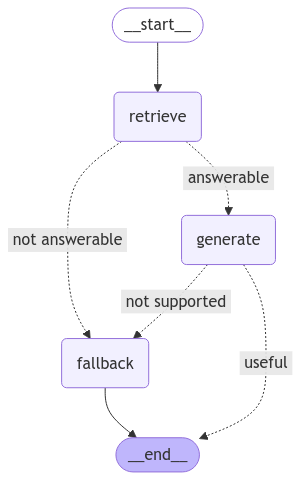

In [95]:
from IPython.display import Image, display

try:
    # Generate the image and save it to disk
    img_data = graph.get_graph(xray=True).draw_mermaid_png()
    with open('graph_image.png', 'wb') as f:
        f.write(img_data)
    display(Image(img_data))
except Exception:
    # This requires some extra dependencies and is optional
    pass
